<a href="https://colab.research.google.com/github/sxsmg/ai-notebooks/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

In [47]:
import numpy as np
%pylab inline

from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample', 'axes', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [29]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]


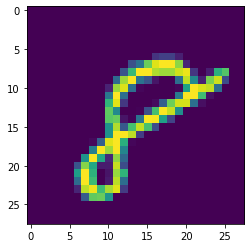

In [30]:
import matplotlib.pyplot as plt

mnist_image = X_train[59999, :].reshape(28, 28)

plt.imshow(mnist_image)
plt.show()

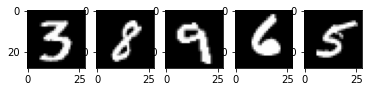

In [31]:
num_examples = 5
seed = 147197952744
rng = np.random.default_rng(seed)

fig, axes = plt.subplots(1, num_examples)
for sample, ax in zip(rng.choice(X_train, size=num_examples, replace=False), axes):
  ax.imshow(sample.reshape(28, 28), cmap="gray")

In [32]:
print("The data type of training images: {}".format(X_train.dtype))
print("The data type of training images: {}".format(X_test.dtype))


The data type of training images: uint8
The data type of training images: uint8


In [33]:
training_sample, test_sample = 1000, 1000
training_images = X_train[0:training_sample] / 255
test_images = X_test[0:test_sample] / 255

In [34]:
print("The data type of training images {}".format(training_images.dtype))
print("The data type of training images {}".format(test_images.dtype))

The data type of training images float64
The data type of training images float64


In [35]:
print("The data type of training labels: {}".format(Y_train.dtype))
print("The data type of test labels {}".format(Y_test.dtype))

The data type of training labels: uint8
The data type of test labels uint8


In [36]:
#ONE HOT ENCODING

def one_hot_encoding(labels, dimension=10):

  one_hot_labels = labels[..., None] == np.arange(dimension)[None]

  return one_hot_labels.astype(np.float64)

In [37]:
training_labels = one_hot_encoding(Y_train[:training_sample])
test_labels = one_hot_encoding(Y_test[:test_sample])

In [38]:
print(training_labels[0])
print(training_labels[1])
print(training_labels[2])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [39]:
print(Y_train[0])
print(Y_train[1])
print(Y_train[2])

5
0
4


In [40]:
seed  = 884736743
rng = np.random.default_rng(seed)

In [41]:
def relu(x):
  return (x >= 0) * x

def relu2deriv(output):
  return output >= 0

In [78]:
learning_rate = 0.005
epochs = 200
hidden_size = 100
pixels_per_image = 784
num_labels = 10


In [43]:
weights_1 = 0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1
weights_2 = 0.2 * rng.random((hidden_size, num_labels)) - 0.1

In [79]:
# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
for j in range(epochs):

    #################
    # Training step #
    #################

    # Set the initial loss/error and the number of accurate predictions to zero.
    training_loss = 0.0
    training_accurate_predictions = 0

    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly.
    for i in range(len(training_images)):
        # Forward propagation/forward pass:
        # 1. The input layer:
        #    Initialize the training image data as inputs.
        layer_0 = training_images[i]
        # 2. The hidden layer:
        #    Take in the training image data into the middle layer by
        #    matrix-multiplying it by randomly initialized weights.
        layer_1 = np.dot(layer_0.flatten(), weights_1)
        # 3. Pass the hidden layer's output through the ReLU activation function.
        layer_1 = relu(layer_1)
        # 4. Define the dropout function for regularization.
        dropout_mask = rng.integers(low=0, high=2, size=layer_1.shape)
        # 5. Apply dropout to the hidden layer's output.
        layer_1 *= dropout_mask * 2
        # 6. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights.
        #    Produce a 10-dimension vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)

        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model.
        training_loss += np.sum((training_labels[i] - layer_2) ** 2)
        # 2. Increment the accurate prediction count.
        training_accurate_predictions += int(
            np.argmax(layer_2) == np.argmax(training_labels[i])
        )
        # 3. Differentiate the loss function/error.
        layer_2_delta = training_labels[i] - layer_2
        # 4. Propagate the gradients of the loss function back through the hidden layer.
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients.
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients.
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)

    # Store training set losses and accurate predictions.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)

    ###################
    # Evaluation step #
    ###################

    # Evaluate model performance on the test set at each epoch.

    # Unlike the training step, the weights are not modified for each image
    # (or batch). Therefore the model can be applied to the test images in a
    # vectorized manner, eliminating the need to loop over each image
    # individually:

    results = relu(test_images.reshape(1000,784) @ weights_1) @ weights_2

    # Measure the error between the actual label (truth) and prediction values.
    test_loss = np.sum((test_labels - results) ** 2)

    # Measure prediction accuracy on test set
    test_accurate_predictions = np.sum(
        np.argmax(results, axis=1) == np.argmax(test_labels, axis=1)
    )

    # Store test set losses and accurate predictions.
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)


    # Summarize error and accuracy metrics at each epoch
    print(
        "\n"
        + "Epoch: "
        + str(j)
        + " Training set error:"
        + str(training_loss / float(len(training_images)))[0:5]
        + " Training set accuracy:"
        + str(training_accurate_predictions / float(len(training_images)))
        + " Test set error:"
        + str(test_loss / float(len(test_images)))[0:5]
        + " Test set accuracy:"
        + str(test_accurate_predictions / float(len(test_images)))
    )


Epoch: 0 Training set error:0.432 Training set accuracy:0.799 Test set error:0.436 Test set accuracy:0.783

Epoch: 1 Training set error:0.412 Training set accuracy:0.817 Test set error:0.437 Test set accuracy:0.782

Epoch: 2 Training set error:0.400 Training set accuracy:0.823 Test set error:0.436 Test set accuracy:0.79

Epoch: 3 Training set error:0.408 Training set accuracy:0.827 Test set error:0.438 Test set accuracy:0.778

Epoch: 4 Training set error:0.403 Training set accuracy:0.817 Test set error:0.429 Test set accuracy:0.798

Epoch: 5 Training set error:0.393 Training set accuracy:0.833 Test set error:0.427 Test set accuracy:0.797

Epoch: 6 Training set error:0.405 Training set accuracy:0.833 Test set error:0.430 Test set accuracy:0.783

Epoch: 7 Training set error:0.412 Training set accuracy:0.813 Test set error:0.434 Test set accuracy:0.798

Epoch: 8 Training set error:0.391 Training set accuracy:0.836 Test set error:0.431 Test set accuracy:0.789

Epoch: 9 Training set error:

In [74]:
(test_images.reshape(1000, 784)).shape, weights_1.shape, weights_2.shape

((1000, 784), (784, 100), (100, 10))

In [75]:
result = relu(test_images.reshape(1000,784) @ weights_1) @ weights_2

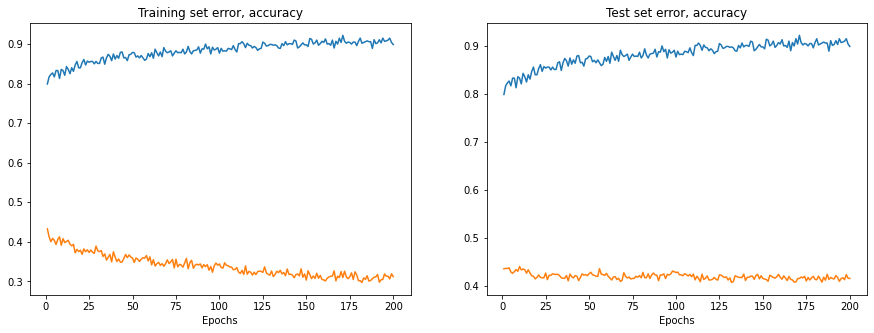

In [80]:
# The training set metrics.
y_training_error = [
    store_training_loss[i] / float(len(training_images))
    for i in range(len(store_training_loss))
]
x_training_error = range(1, len(store_training_loss) + 1)
y_training_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_training_accuracy = range(1, len(store_training_accurate_pred) + 1)

# The test set metrics.
y_test_error = [
    store_test_loss[i] / float(len(test_images)) for i in range(len(store_test_loss))
]
x_test_error = range(1, len(store_test_loss) + 1)
y_test_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_test_accuracy = range(1, len(store_test_accurate_pred) + 1)

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Training set error, accuracy")
axes[0].plot(x_training_accuracy, y_training_accuracy, label="Training set accuracy")
axes[0].plot(x_training_error, y_training_error, label="Training set error")
axes[0].set_xlabel("Epochs")
axes[1].set_title("Test set error, accuracy")
axes[1].plot(x_test_accuracy, y_test_accuracy, label="Test set accuracy")
axes[1].plot(x_test_error, y_test_error, label="Test set error")
axes[1].set_xlabel("Epochs")
plt.show()